# Real-Time Stability Assessment in Smart Grids: A Deep Learning Approach
### Simran(190906474)
### Koyena Bose(190906540)
### Meghana Rao (190906536)

## Objectives


1. Take the opportunity to assess the influence of deep learning architecture (number and size of hidden layers), number of epochs and the relevance of dataset augmentation.
2. We aim to work on a modified FNN(Feedforward Neural Network) for real-time assessment of transient stability(TS) with prediction capability before fault clearance.
3. We wish to focus on a comprehensive assessment through numerous fault scenario simulations, including various fault duration, fault location, and load profile intervals.


## The dataset

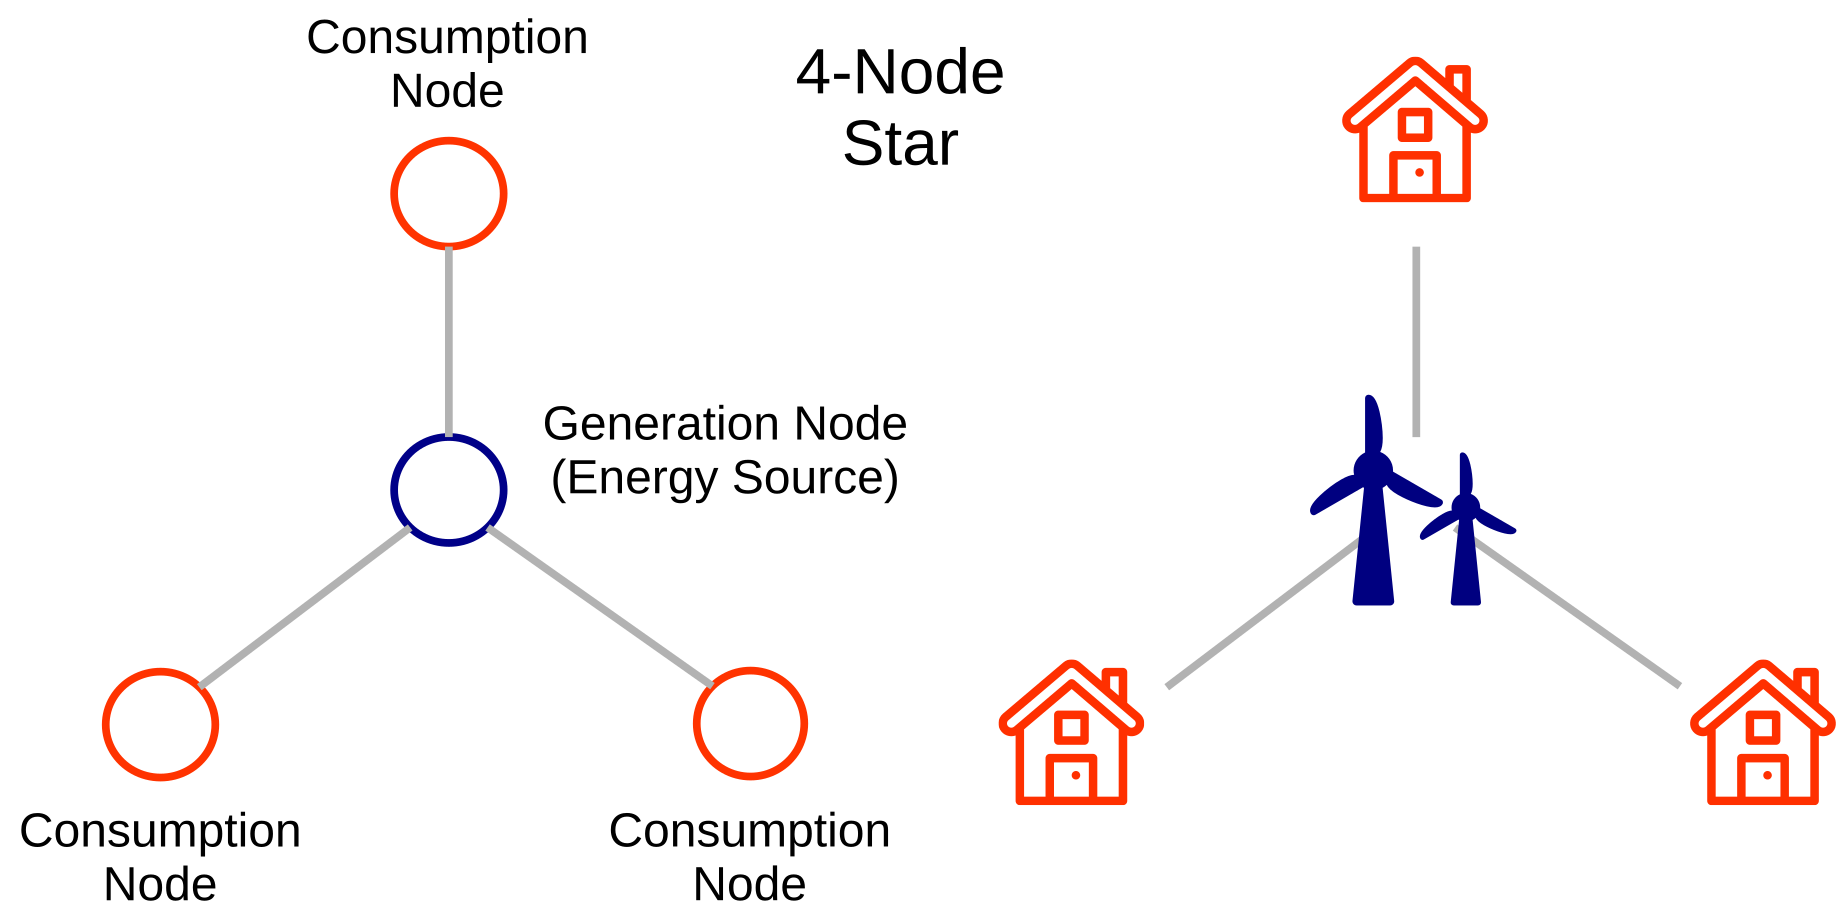

<p style="text-align: justify">The dataset chosen for this machine learning exercise has a synthetic nature and contains results from simulations of grid stability for a reference 4-node star network, as shown above.</p>

<p style="text-align: justify">The dataset chosen for this machine learning exercise has a synthetic nature and contains results from simulations of grid stability for a reference 4-node star network.
The dataset has 60,000 observations. It contains 12 primary predictive features and one dependent variable.
</p>
<p><b>Predictive features</b>:</p>
<ol>
    <li>'tau1' to 'tau4': the reaction time of each network participant, a real value within the range 0.5 to 10 ('tau1' corresponds to the supplier node, 'tau2' to 'tau4' to the consumer nodes);</li>
    <li>'p1' to 'p4': nominal power produced (positive) or consumed (negative) by each network participant, a real value within the range -2.0 to -0.5 for consumers ('p2' to 'p4'). As the total power consumed equals the total power generated, p1 (supplier node) = - (p2 + p3 + p4);</li>
    <li>'g1' to 'g4': price elasticity coefficient (an economic term that shows the percentage change in quantity demanded due to a change in the price of goods and services) for each network participant, a real value within the range 0.05 to 1.00 ('g1' corresponds to the supplier node, 'g2' to 'g4' to the consumer nodes; 'g' stands for 'gamma');</li>
</ol>
<p><b>Dependent variables</b>:</p>
<ol>
    <li>'stabf': a categorical (binary) label ('stable' or 'unstable').</li>
</ol>



## Initial setup

### Importing libraries

<p style="text-align: justify">Along with traditional libraries imported for tensor manipulation, mathematical operations and graphics development, three scikit-learn modules (StandardScaler as a scaler, confusion_matrix as the model performance metric of choice and KFold as the cross validation engine) and two Keras deep learning objects (Sequential and Dense) are used in this exercise.</p>

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

from keras.models import Sequential
from keras.layers import Dense

### Plot functions

<p style="text-align: justify">Functions were developed to assist with graphical analysis of specific dataset elements (features or observations) and mapping correlation. Please refer to the respective docstrings below for details. Note that all function variable names, by coding principle, start with the "f_" string, allowing for containerized processing within the function execution environment, not affecting global variables.</p>

In [10]:
def assessment(f_data, f_y_feature, f_x_feature):
    """
    Develops and displays a histogram and a scatter plot for a dependent / independent variable pair from
    a dataframe and, optionally, highlights a specific observation on the plot in a different color (red).
    Also optionally, if an independent feature is not informed, the scatterplot is not displayed.

    f_data      Tensor containing the dependent / independent variable pair.
                Pandas dataframe
    f_y_feature Dependent variable designation.
                String
    f_x_feature Independent variable designation.
                String
    """

    f_fig = plt.subplots(1, 1, figsize=(16,4))
    f_chart = sns.scatterplot(x=f_x_feature, y=f_y_feature, data=f_data, legend=False)
    f_chart.set_xlabel(f_x_feature,fontsize=10)
    f_chart.set_ylabel(f_y_feature,fontsize=10)

    plt.show()

    
def correlation_map(f_data, f_feature):
    """
    Develops and displays a heatmap plot referenced to a primary feature of a dataframe, highlighting
    the correlation among the 'n' mostly correlated features of the dataframe.
    
    f_data      Tensor containing all relevant features, including the primary.
                Pandas dataframe
    f_feature   The primary feature.
                String
    """
    f_correlation = f_data.corr()
    f_fig, f_ax = plt.subplots(figsize=(20, 10))
    sns.heatmap(f_correlation, annot=True, annot_kws={"size": 8}, cmap="PRGn")
    plt.show()

### Importing required datasets into dataframes

<p style="text-align: justify">The dataset (60,000 observations) is imported. The dependent variable is map encoded ('stable' replaced with 1, 'unstable' with 0). At last, the 60,000 observations are shuffled.</p>

In [11]:
sns.set()
data = pd.read_csv('/content/smart_grid_stability_augmented.csv')

map1 = {'unstable': 0, 'stable': 1}
data['stabf'] = data['stabf'].replace(map1)

data = data.sample(frac=1)

## Exploratory data analysis

<p style="text-align: justify">A glimpse at the dataset structure confirms observation shuffling and the close relationship between the two original dependent variables 'stab' and 'stabf'.</p>

In [12]:
data.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
44114,2.317045,8.209058,5.275024,1.117904,3.395610,-1.760214,-0.565802,-1.069594,0.214070,0.778766,0.575226,0.399912,0.005764,0
50323,6.556374,4.371795,5.591669,3.939636,4.695126,-1.406557,-1.702318,-1.586250,0.540497,0.084367,0.261829,0.552802,0.004640,0
14812,6.394991,7.922658,1.860795,7.989705,5.047816,-1.455628,-1.650856,-1.941332,0.421246,0.318310,0.874735,0.625458,0.017172,0
21750,7.506790,7.170695,7.769541,1.742737,4.309748,-1.534636,-1.966689,-0.808423,0.393577,0.673648,0.340700,0.485576,0.022819,0
43201,4.446340,7.286531,9.944701,2.375881,3.332603,-1.227077,-0.837642,-1.267884,0.586206,0.469997,0.911691,0.259483,0.039839,0


### Feature assessment

<p style="text-align: justify">Distribution patterns and the relationship with the 'stab' dependent variable is charted for each of the 12 dataset features.</p>
<p style="text-align: justify">As this data comes from simulations with predetermined fixed ranges for all features, distributions are pretty much uniform across the board, with the exception of 'p1' (absolute sum of 'p2', 'p3' and 'p4').</p>

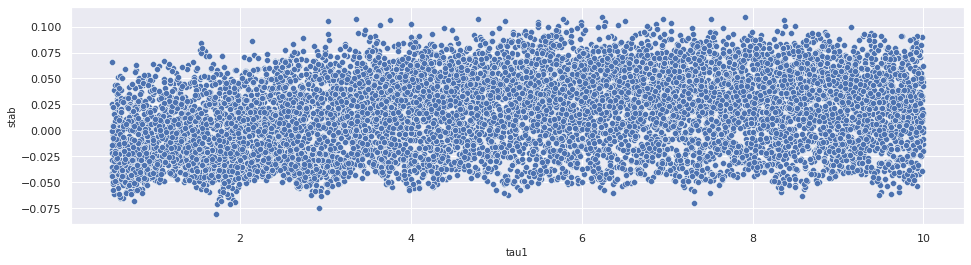

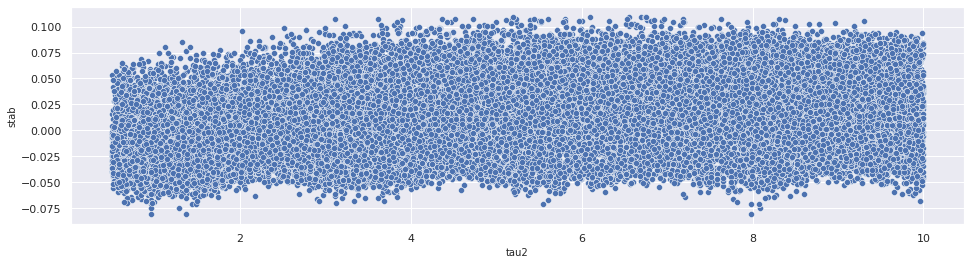

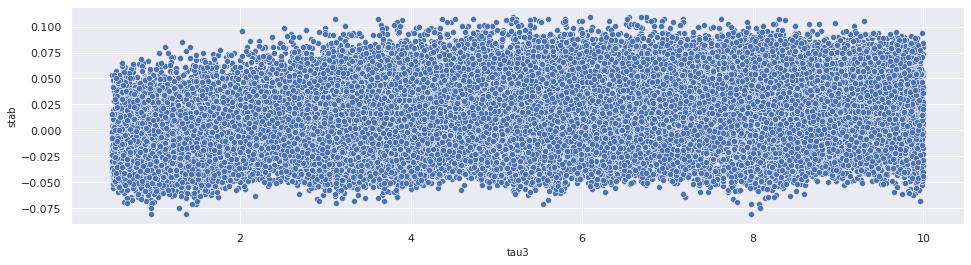

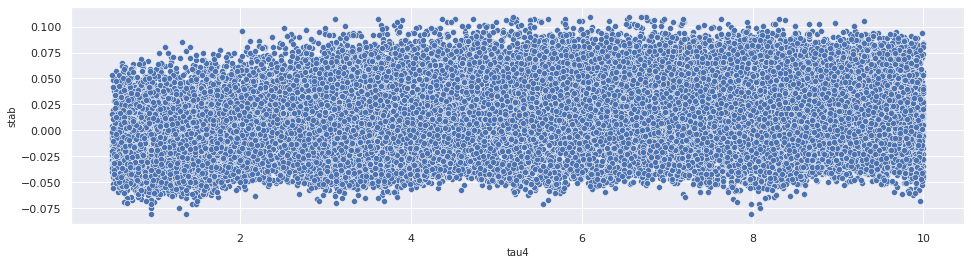

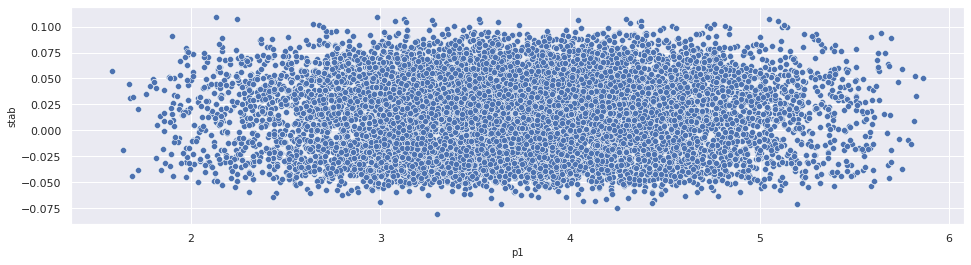

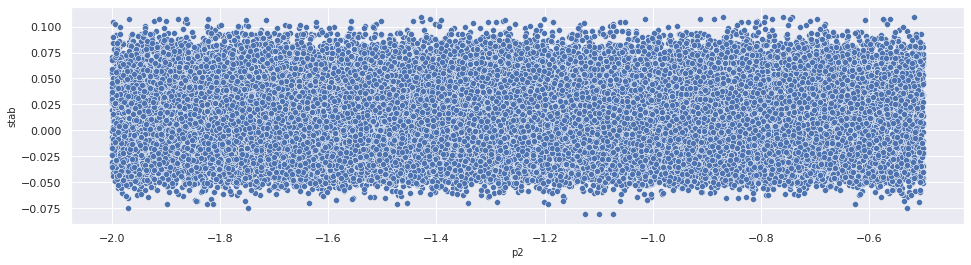

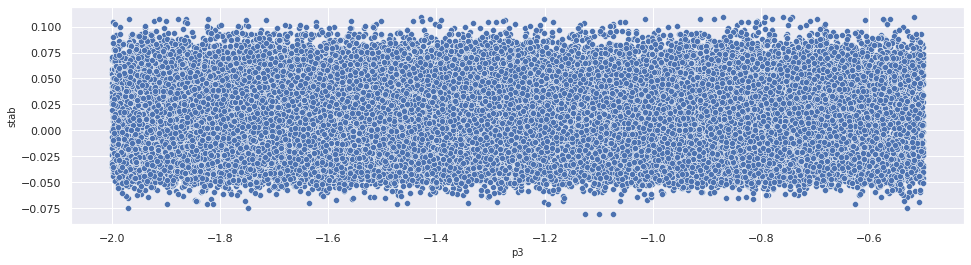

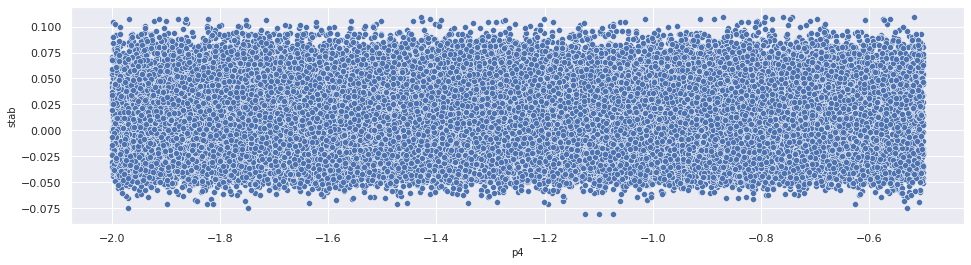

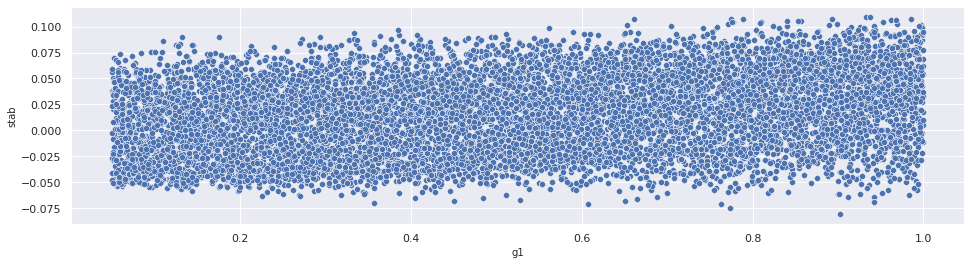

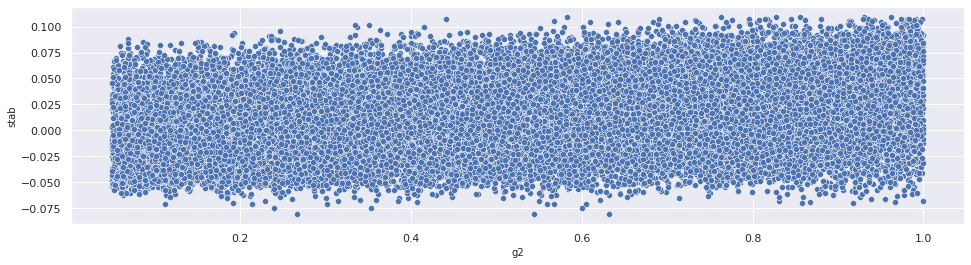

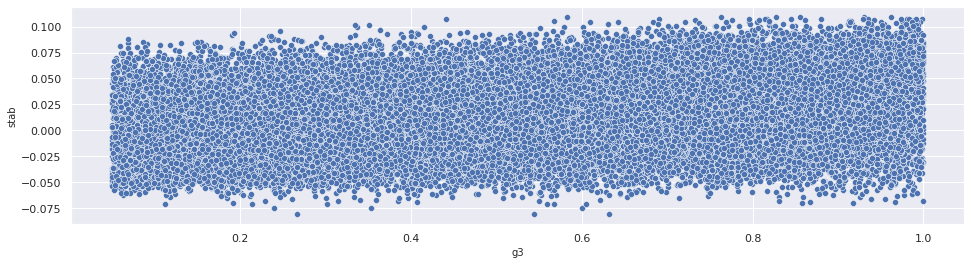

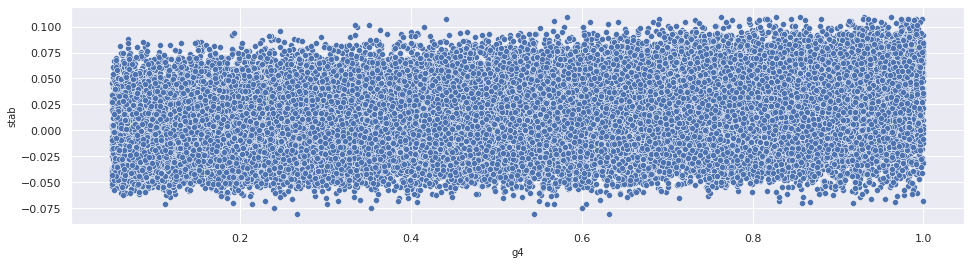

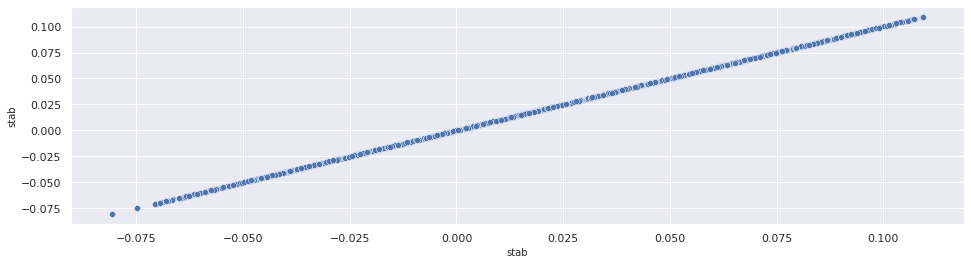

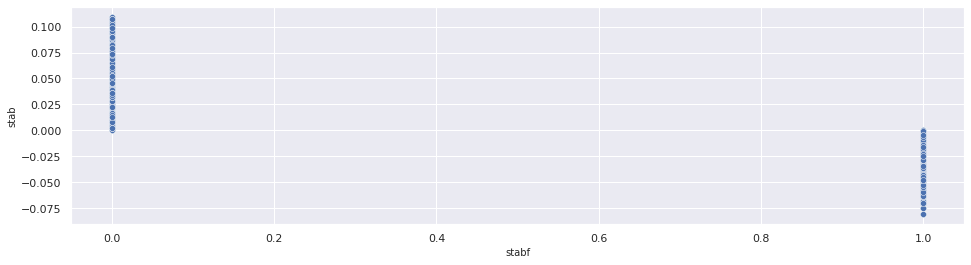

In [13]:
for column in data.columns:
    assessment(data, 'stab', column)

<p style="text-align: justify">The proportion of observations related to 'unstable' and 'stable' scenarios is mapped.</p>

In [14]:
print(f'Split of "unstable" (0) and "stable" (1) observations in the original dataset:')
print(data['stabf'].value_counts(normalize=True))

Split of "unstable" (0) and "stable" (1) observations in the original dataset:
0    0.638
1    0.362
Name: stabf, dtype: float64


### Correlation Matrix

<p style="text-align: justify">It is important to verify the correlation between each numerical feature and the dependent variable, as well as correlation among numerical features leading to potential undesired colinearity. The heatmap below provides an overview of correlation between the dependent variable ('stabf') and the 12 numerical features. Also, correlation between 'p1' and its components 'p2', 'p3' and 'p4' is above average, as expected, but not as high to justify any removal. </p>

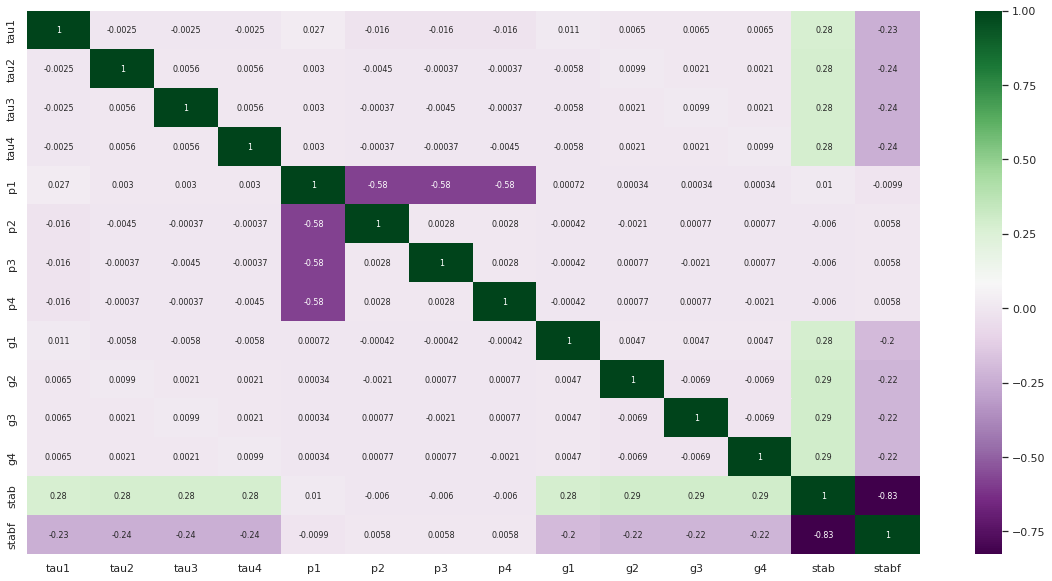

In [15]:
correlation_map(data, 'stabf')

### Segregating train and test sets

<p style="text-align: justify">As anticipated, the features dataset will contain all 12 original predictive features, while the label dataset will contain only 'stabf'.</p>
<p style="text-align: justify">In addition, as the dataset has already been shuffled, the training set will receive the first 54,000 observations, while the testing set will accommodate the last 6,000.</p>
<p style="text-align: justify">Even considering that the dataset is large enough and well behaved, the percentage of 'stable' and 'unstable' observations is computed for both training and testing sets, just to make sure that the original dataset distribution is maintained after the split - which proved to be the case.</p>
<p style="text-align: justify">After splitting, Pandas dataframes and series are transformed into Numpy arrays for the remainder of the exercise.</p>

In [16]:
X = data.iloc[:, :12]
y = data.iloc[:, 13]

X_training = X.iloc[:54000, :]
y_training = y.iloc[:54000]

X_testing = X.iloc[54000:, :]
y_testing = y.iloc[54000:]

In [17]:
X_training = X_training.values
y_training = y_training.values

X_testing = X_testing.values
y_testing = y_testing.values

### Feature scaling

<p style="text-align: justify">In preparation for machine learning, scaling is performed based on (fitted to) the training set and applied (with the 'transform' method) to both training and testing sets.</p>

In [18]:
scaler = StandardScaler()
X_training = scaler.fit_transform(X_training)
X_testing = scaler.transform(X_testing)

## Deep Learning

### Model Definition

<p style="text-align: justify">The artificial neural network (ANN) architecture reflects an sequential structure with:</p>
<ul>
    <li>one input layer (12 input nodes);</li>
    <li>three hidden layers (24, 24 and 12 nodes, respectively);</li>
    <li>one single-node output layer.</li>
</ul>
<p style="text-align: justify">As features are numerical real numbers within ranges, the choice of 'relu' as the activation function for hidden layers seems straightforward. Similarly, as this is a logistic classification exercise, where the output is binary ('0' for 'unstable', '1' for 'stable', following the map coding used), the choice of 'sigmoid' as activation for the output layers seems obvious.</p>
<p style="text-align: justify">Compilation with 'adam' as optimizer and 'binary_crossentropy' as the loss function follow the same logic. The fitting performance will be assessed using 'accuracy' as the metric of choice.</p>

<img src="https://i.imgur.com/Uu57iWd.png" width="950" height="600">

In [19]:
# ANN initialization
classifier = Sequential()

# Input layer and first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 12))

# Second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Third hidden layer
classifier.add(Dense(units = 12, kernel_initializer = 'uniform', activation = 'relu'))

# Single-node output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# ANN compilation
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


### Model fitting

<p style="text-align: justify">Even considering that data is well behaved and in general uniformly distributed, a cross-validation based fitting is proposed. KFold is the cross-validation engine selected, and 10 different validation sets will be utilized.</p>

In [20]:
cross_val_round = 1
print(f'Model evaluation\n')

for train_index, val_index in KFold(10, shuffle=True, random_state=10).split(X_training):
    x_train, x_val = X_training[train_index], X_training[val_index]
    y_train,y_val = y_training[train_index], y_training[val_index]
    classifier.fit(x_train, y_train, epochs=50, verbose=0)
    classifier_loss, classifier_accuracy = classifier.evaluate(x_val, y_val)
    print(f'Round {cross_val_round} - Loss: {classifier_loss:.4f} | Accuracy: {classifier_accuracy * 100:.2f} %')
    cross_val_round += 1

Model evaluation

169/169 [==============================] - 1s 3ms/step - loss: 0.0891 - accuracy: 0.9617
Round 1 - Loss: 0.0891 | Accuracy: 96.17 %
169/169 [==============================] - 0s 3ms/step - loss: 0.0804 - accuracy: 0.9681
Round 2 - Loss: 0.0804 | Accuracy: 96.81 %
169/169 [==============================] - 0s 3ms/step - loss: 0.0555 - accuracy: 0.9776
Round 3 - Loss: 0.0555 | Accuracy: 97.76 %
169/169 [==============================] - 0s 3ms/step - loss: 0.0636 - accuracy: 0.9757
Round 4 - Loss: 0.0636 | Accuracy: 97.57 %
169/169 [==============================] - 0s 3ms/step - loss: 0.0620 - accuracy: 0.9733
Round 5 - Loss: 0.0620 | Accuracy: 97.33 %
169/169 [==============================] - 0s 3ms/step - loss: 0.0418 - accuracy: 0.9822
Round 6 - Loss: 0.0418 | Accuracy: 98.22 %
169/169 [==============================] - 0s 3ms/step - loss: 0.0348 - accuracy: 0.9852
Round 7 - Loss: 0.0348 | Accuracy: 98.52 %
169/169 [==============================] - 0s 3ms/step - l

### Predicting smart grid stability

<p style="text-align: justify">After fitting the model to the training set, it is time to extract predictions for the testing set and segregate those above the 'threshold' of 0.5 ('unstable' cases below the threshold, 'stable' cases above it).</p>

In [21]:
y_pred = classifier.predict(X_testing)
y_pred[y_pred <= 0.5] = 0
y_pred[y_pred > 0.5] = 1

## Results

### Classification performance - Confusion matrix

In [22]:
cm = pd.DataFrame(data=confusion_matrix(y_testing, y_pred, labels=[0, 1]),
                  index=["Actual Unstable", "Actual Stable"],
                  columns=["Predicted Unstable", "Predicted Stable"])
cm

,Predicted Unstable,Predicted Stable
Actual Unstable,3759,46
Actual Stable,55,2140


In [23]:
print(f'Accuracy per the confusion matrix: {((cm.iloc[0, 0] + cm.iloc[1, 1]) / len(y_testing) * 100):.2f}%')

Accuracy per the confusion matrix: 98.32%


## Conclusion

<p style="text-align: justify">Specific aspects of this deep learning exercise demand special attention:</p>
<ol>
    <li style="text-align: justify">Deep learning proved to be an outstanding prediction tool for this particular application. Even considering that the dataset is well behaved and needed no significant preprocessing, the <b>high accuracies</b> obtained on the testing set confirm that a deep learning model may be safely considered. It would though be up to a smart grid operator to confirm if the accuracy level obtained with deep learning would suffice in practical terms (live network);</li>
    <li style="text-align: justify">An <b>increased number of epochs</b> considered during fitting also plays a major role. It is evident that the more the model is exposed to the training set, the better the prediction accuracy;</li>
</ol>